In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from linear_classifier import *
from data_utils import load_CIFAR10
cifar10_path = '../datasets/cifar-10-batches-py'
X_train,y_train,X_test,y_test = load_CIFAR10(cifar10_path)
print("Training data shape : ",repr(X_train.shape))
print("Training labels shape : ",repr(y_train.shape))
print("Test data shape : ",repr(X_test.shape))
print("Test labels shape : ",repr(y_test.shape))
print()

Training data shape :  (50000, 32, 32, 3)
Training labels shape :  (50000,)
Test data shape :  (10000, 32, 32, 3)
Test labels shape :  (10000,)



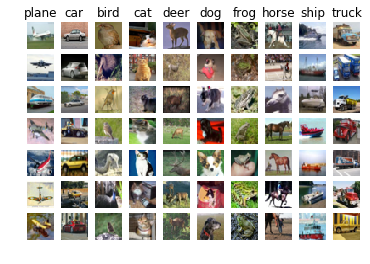

In [2]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx_val in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx_val].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
num_traing = 49000
num_validation = 1000
num_test = 1000
mask = range(num_traing,num_traing + num_validation)
X_val = X_train[mask] #(1000,32,32,3)
y_val = y_train[mask] #(1,1000)
mask = range(num_traing)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

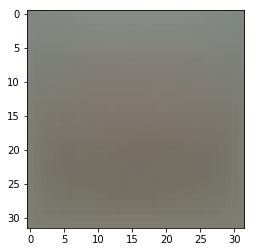

In [4]:
# Preprocessing1: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))    # (49000,3072)
X_val = np.reshape(X_val, (X_val.shape[0], -1))          # (1000,3072)
X_test = np.reshape(X_test, (X_test.shape[0], -1))       # (1000,3072)

# Preprocessing2: subtract the mean image
mean_image = np.mean(X_train, axis=0)       # (1,3072)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# Visualize the mean image
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

In [5]:
# Bias trick, extending the data
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])    # (49000,3073)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])          # (1000,3073)
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])       # (1000,3073)

In [6]:
# Use the validation set to tune hyperparameters (regularization strength
# and learning rate).
learning_rates = [1e-7, 2e-6]
regularization_strengths = [5e4, 1e5]
results = {}
best_val = -1    # The highest validation accuracy that we have seen so far.
best_svm = None   # The LinearSVM object that achieved the highest validation rate.
iterations = 1500

#当learning_rates 为 5e-5时，loss和梯度在100个Iteration之后直接爆炸
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iterations)
        train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == train_pred)
        val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == val_pred)
        results[(lr, rs)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm

iteration 0 / 1500: loss 799.954839
iteration 100 / 1500: loss 291.087639
iteration 200 / 1500: loss 109.358003
iteration 300 / 1500: loss 43.455191
iteration 400 / 1500: loss 18.827062
iteration 500 / 1500: loss 10.462515
iteration 600 / 1500: loss 6.972358
iteration 700 / 1500: loss 5.396779
iteration 800 / 1500: loss 5.858866
iteration 900 / 1500: loss 5.049786
iteration 1000 / 1500: loss 5.625219
iteration 1100 / 1500: loss 5.655046
iteration 1200 / 1500: loss 5.821553
iteration 1300 / 1500: loss 5.523179
iteration 1400 / 1500: loss 5.434111
iteration 0 / 1500: loss 1568.135531
iteration 100 / 1500: loss 210.912258
iteration 200 / 1500: loss 32.878736
iteration 300 / 1500: loss 9.373397
iteration 400 / 1500: loss 5.782685
iteration 500 / 1500: loss 5.394844
iteration 600 / 1500: loss 5.766355
iteration 700 / 1500: loss 5.765053
iteration 800 / 1500: loss 5.617126
iteration 900 / 1500: loss 5.450776
iteration 1000 / 1500: loss 5.144573
iteration 1100 / 1500: loss 5.641310
iteration 

In [7]:
for lr,rs in sorted(results):
    train_acc,val_acc = results[(lr,rs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' %
                                (lr, rs, train_acc, val_acc))

print('Best validation accuracy achieved during validation: %f' % best_val) # around 38.2%

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.371041 val accuracy: 0.382000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.358224 val accuracy: 0.377000
lr 2.000000e-06 reg 5.000000e+04 train accuracy: 0.253980 val accuracy: 0.277000
lr 2.000000e-06 reg 1.000000e+05 train accuracy: 0.222551 val accuracy: 0.210000
Best validation accuracy achieved during validation: 0.382000


In [9]:
print(np.min([[1,2],[3,4]]))

1


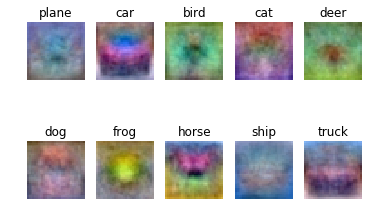

In [15]:
# Visualize the learned weights for each class
W = best_svm.W[:-1, :]   # strip out the bias
"""
一行一行的往后加变为只有一行
所以展开的时候先（32再32再3）
             （32再32再3）
              ...                 7
             （32再32再3）

"""
W = W.reshape(32, 32, 3, 10)
w_min, w_max = np.min(W), np.max(W)
classes = ['plane', 'car', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
#     print(W[:, :, :, i].shape) # (32, 32, 3)
#     print(W[:, :, :, i])
#     print(W[:, :, :, i].squeeze().shape) #(32, 32, 3) 
#     print(W[:, :, :, i].squeeze())
    wimg = 255.0 * (W[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
#     print(wimg.shape) # (32, 32, 3)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

In [16]:
"""
>>> x = np.array([[[0], [1], [2]]])
>>> x.shape
(1, 3, 1)
>>> np.squeeze(x).shape
(3,)
>>> np.squeeze(x)
array([0, 1, 2])
>>> np.squeeze(x, axis=0).shape
(3, 1)
>>> np.squeeze(x, axis=1).shape
Traceback (most recent call last):
...
ValueError: cannot select an axis to squeeze out which has size not equal to one
>>> np.squeeze(x, axis=2).shape
(1, 3)

"""

'\nx = np.array([[[0], [1], [2]]])\nx.shape\n(1, 3, 1)\nnp.squeeze(x).shape\n(3,)\nnp.squeeze(x)\narray([0, 1, 2])\nnp.squeeze(x, axis=0).shape\n(3, 1)\nnp.squeeze(x, axis=1).shape\nTraceback (most recent call last):\n\nValueError: cannot select an axis to squeeze out which has size not equal to one\nnp.squeeze(x, axis=2).shape\n(1, 3)\n\n'

In [17]:
# Evaluate the best svm on test set
test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == test_pred)     # around 37.1%
print('LinearSVM on raw pixels of CIFAR-10 final test set accuracy: %f' % test_accuracy)

LinearSVM on raw pixels of CIFAR-10 final test set accuracy: 0.370000
